In [ ]:
#cmd 파일파일

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [2]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [3]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [4]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [5]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [6]:
#FFT(Fast Fourier Transform)는 아주 적은 계산량으로 
#이산 푸리에 변환값을 계산하는 알고리즘을 말한다. 
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    # nomalize위한 코드
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [7]:
#소리 데이터의 무의미한 부분은 식병을 어렵게 하기 때문에
#소리의 역치를 이용해 그런 부분을 제거하는 함수
#signal envloperk rmfjsrjek.
#thresh hold값은 0.0005로 셋팅하는게 이분에겐 먹혔지만
#이상하게 나온다면 알아서들 조절해봐라.
def envelope(y, rate, threshold):
    mask=[]
    #가끔 마이너스감 절댓값
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [21]:
df = pd.read_csv('dataset.csv')

In [22]:
#레이블과 fname밖에 존재하지 않음
df.set_index('fname', inplace=True)

In [23]:
df.label

fname
A.wav         scream
A-2.wav       scream
A-3.wav       scream
A-4.wav       scream
A-5.wav       scream
A-6.wav       scream
A-7.wav       scream
A-8.wav       scream
A-9.wav       scream
A-10.wav      scream
A-11.wav      scream
A-12.wav      scream
B.wav         scream
B-2.wav       scream
B-3.wav       scream
B-4.wav       scream
B-5.wav       scream
B-6.wav       scream
B-7.wav       scream
B-8.wav       scream
B-9.wav       scream
B-10.wav      scream
B-11.wav      scream
B-12.wav      scream
C.wav         scream
C-2.wav       scream
C-3.wav       scream
C-4.wav       scream
C-5.wav       scream
C-6.wav       scream
              ...   
gg-7.wav        talk
gg-8.wav        talk
gg-9.wav        talk
gg-10.wav       talk
gg-11.wav       talk
gg-12.wav       talk
hh.wav          talk
hh-2.wav        talk
hh-3.wav        talk
hh-4.wav        talk
hh-5.wav        talk
hh-6.wav        talk
hh-7.wav        talk
hh-8.wav        talk
hh-9.wav        talk
hh-10.wav       talk
hh-11.w

In [24]:
#DataFrame에 length파악해서 컬럼추가
for f in df.index:
    rate, signal = wavfile.read('wavfiles/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [25]:
classes = list(np.unique(df.label))

In [26]:
#같은 레이블마다 더해서 평균 구하기
class_dist = df.groupby(['label'])['length'].mean()

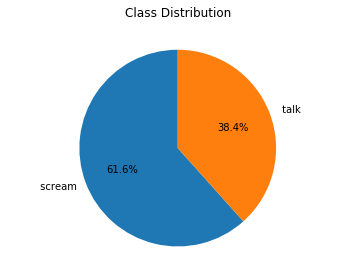

In [27]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y = 1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
      shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [28]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [29]:
#클래스 이름따라 데이터 librosa에 넣기
for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    # librosa에 load하면 signal과 sr즉 sound rate가 발생됩니다.
    # signal은 음파를 행렬로 표현한 데이터이고
    # sr은 그 파일의 sound rate를 자동으로 뽑아준다.
    signal, rate = librosa.load('wavfiles/'+wav_file, sr =44100)
    mask = envelope(signal, rate, 0.0005)
    signal=signal[mask]
    signals[c] = signal
    fft[c]= calc_fft(signal,rate)
    
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

IndexError: list index out of range

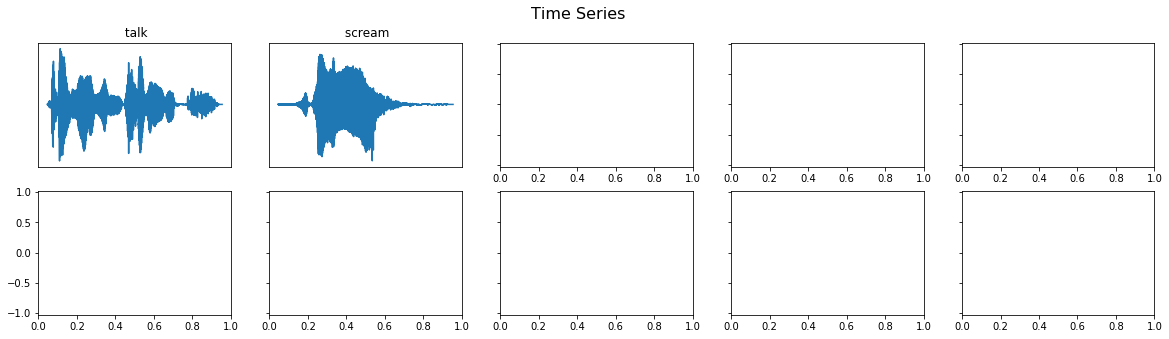

In [30]:
plot_signals(signals)
plt.show()

IndexError: list index out of range

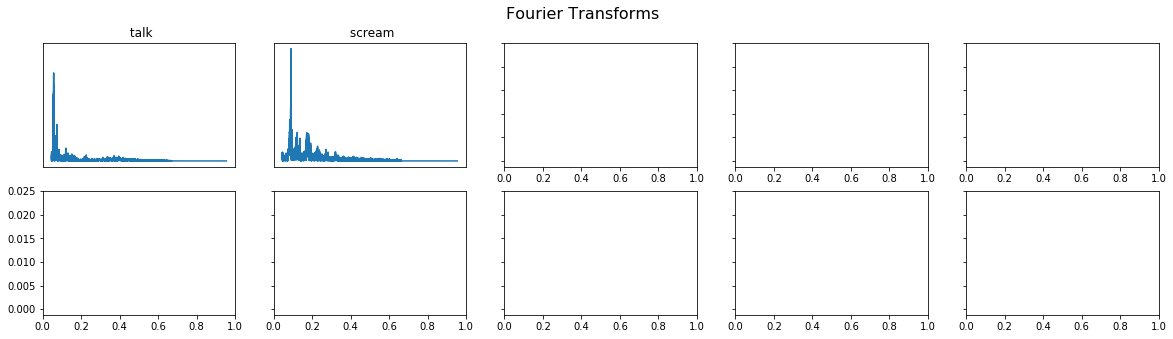

In [31]:
#frequenct가 얼만큼의 비중을 차지하는지가 표현된다.
# 60헤르트라면 일직선에 60만 상승된다.
plot_fft(fft)
plt.show()

IndexError: list index out of range

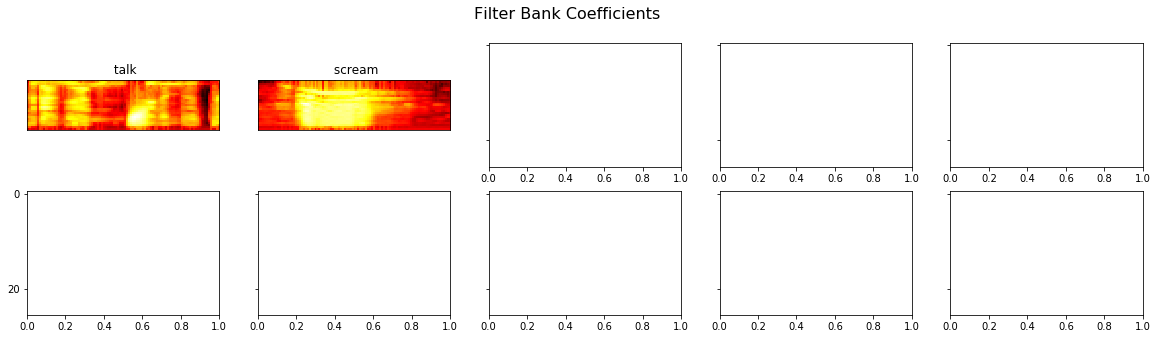

In [32]:
plot_fbank(fbank)
plt.show()

IndexError: list index out of range

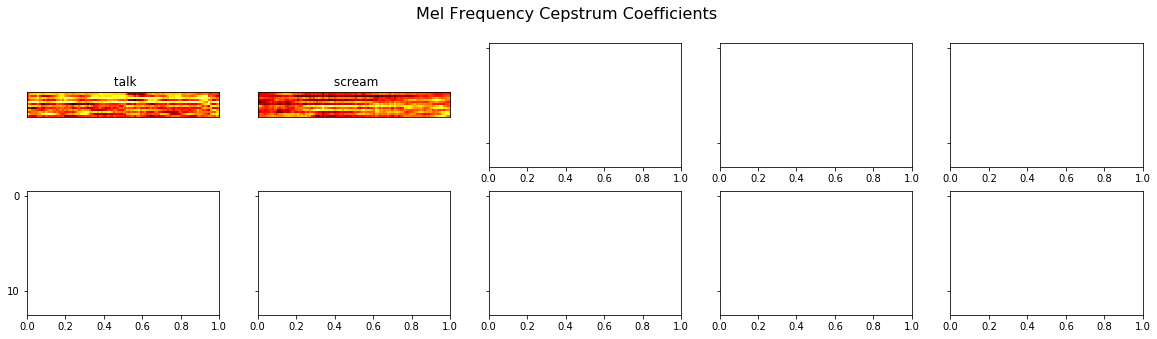

In [33]:
plot_mfccs(mfccs)
plt.show()

In [37]:
if len(os.listdir('clean'))==0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('wavfiles/'+f, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f, rate=rate, data= signal[mask])

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:19<00:00, 11.36it/s]


- die out되는 부분을 없애야 인식을 잘 할수 있다.
- 그래서 필터링을 해야한다. noise 역치를 만든다.
- dead space를 없애야한다. 매우 중요하다.

# 지금까지의 Process
- 오디오 파일을 불러온다
- Noise Threshold를 이용해 무의미한 부분을 제거한다.
- Down Scaling을 한다.
- 정제된 데이터를 clean 폴더에 저장한다.